In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [2]:
import os
from os.path import join
import pandas as pd
from src.config import RESULTS, FIGURES_DIR, ROOT_DIR
from src.calculate_AF_by_cell import calculate_af
#ref_fa = "/data2/genome/human_GRCh38/cellranger/refdata-cellranger-GRCh38-3.0.0/fasta/genome.fa"
ref_fa="/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta"
maxBP = 16571


import numpy as np

Project Directory: /data2/mito_lineage


In [3]:
from matplotlib_venn import venn2

import seaborn as sns
import matplotlib.pyplot as plt

from mplh import cluster_help

fig_utils from mplh
here


In [4]:
os.chdir(ROOT_DIR)

## Files setup

In [5]:
indir=join(RESULTS,"mttrace")
mapq = "mapq_30"
num_reads = 200
flt3 = "CD34_Flt3L_mt_PolydT"
wt = "CD34_mt_PolydT"



flt3_indir = join(indir, flt3,"mapq_30")
wt_indir = join(indir, wt,"mapq_30")

# sc_coverage_flt3_f = join(flt3_indir,"scPileup_concat_200",flt3+"_200_all.coverage.txt.gz")
# sc_coverage_wt_f = join(wt_indir,"scPileup_concat_200",wt + "_200_all.coverage.txt.gz")

coverage_flt3_dir = join(flt3_indir,flt3+"_scPileup_200")
coverage_wt_dir = join(wt_indir,wt+"_scPileup_200")

concat_flt3_dir = join(flt3_indir,"scPileup_concat_200")
concat_wt_dir = join(wt_indir,"scPileup_concat_200")

In [6]:
min_cells=10
min_reads=10
topN=0
min_het_cells=10
het_thresh=0.1

In [7]:
dirname = f"minC{min_cells}_minR{min_reads}_topN{topN}_hetC{min_het_cells}_hetT{het_thresh}"
outdir = join(indir, "lineage_trace/CD34_mt_polydT/report",dirname)
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir

'/data2/mito_lineage/data/processed/mttrace/lineage_trace/CD34_mt_polydT/report'

### Get CD34 with and without Flt3L, first using polydT+mt
### Create allele frequency matrix for both, but add metadata for each cell about which experiment it came from
### Cluster and look

### Additional requirements is to remove poor-quality variants of BQ- see if Erick has the code of the mixture model

In [8]:
print(ref_fa)
print(maxBP)
print(coverage_wt_dir)
print(concat_wt_dir)

/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta
16571
/data2/mito_lineage/data/processed/mttrace/CD34_mt_PolydT/mapq_30/CD34_mt_PolydT_scPileup_200
/data2/mito_lineage/data/processed/mttrace/CD34_mt_PolydT/mapq_30/scPileup_concat_200


In [9]:
wt_AF_by_cell, wt_BQ_by_cell, wt_af, wt_bq_df, wt_nt_df = calculate_af(coverage_wt_dir, concat_wt_dir, ref_fasta=ref_fa,AF_F=None, maxBP=maxBP, topN=topN, min_cells=min_cells, min_reads=min_reads,
                                                                      min_het_cells=min_het_cells, het_thresh=het_thresh)

no alt count 5331
topN 0
Number of positions to keep : 1758
Number of cells to keep : 887
Positions that pass het filter: 157


In [10]:
print(f"Number of positions with heteroplasmy fraction above 0: {(wt_AF_by_cell>0).any(axis=0).sum()}")

Number of positions with heteroplasmy fraction above 0: 157


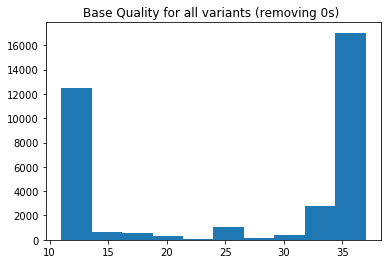

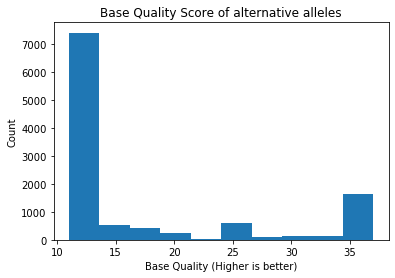

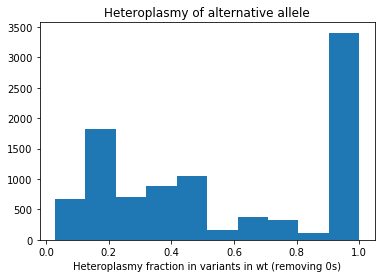

In [11]:
%matplotlib inline
f = plt.figure()
bq_vals = wt_bq_df.values.flatten()
plt.hist(bq_vals[bq_vals>0])
plt.title("Base Quality for all variants (removing 0s) ")
plt.savefig(join(outdir, "wt_base_quality.png"))

plt.figure()
plt.hist(wt_af["Alternative BQ"])
plt.title("Base Quality Score of alternative alleles")
plt.xlabel("Base Quality (Higher is better)")
plt.ylabel("Count")
plt.savefig(join(outdir, "wt_base_quality_altAllele.png"))


f = plt.figure()
af_vals = wt_AF_by_cell.values.flatten()
plt.hist(af_vals[af_vals>0])
plt.title("Heteroplasmy of alternative allele")
plt.xlabel("Heteroplasmy fraction in variants in wt (removing 0s)")
plt.savefig(join(outdir, "wt_heteroplasmy_values.png"))


# flt3

In [12]:
flt3_AF_by_cell, flt3_BQ_by_cell, flt3_af, flt3_bq_df, flt3_nt_df = calculate_af(coverage_flt3_dir, concat_flt3_dir, ref_fasta=ref_fa,AF_F=None, maxBP=maxBP, topN=topN, 
                                                                                 min_cells=min_cells, min_reads=min_reads,
                                                                                min_het_cells=min_het_cells, het_thresh=het_thresh)

no alt count 2142
topN 0
Number of positions to keep : 4130
Number of cells to keep : 2777
Positions that pass het filter: 1937


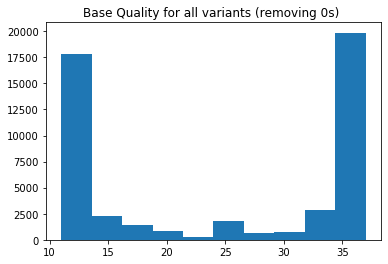

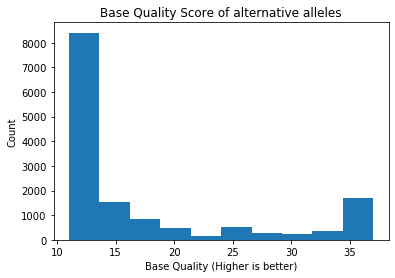

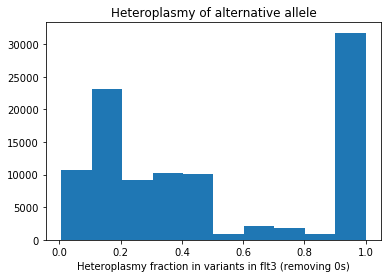

In [13]:
%matplotlib inline
f = plt.figure()
bq_vals = flt3_bq_df.values.flatten()
plt.hist(bq_vals[bq_vals>0])
plt.title("Base Quality for all variants (removing 0s) ")
plt.savefig(join(outdir, "flt3_base_quality.png"))

plt.figure()
plt.hist(flt3_af["Alternative BQ"])
plt.title("Base Quality Score of alternative alleles")
plt.xlabel("Base Quality (Higher is better)")
plt.ylabel("Count")
plt.savefig(join(outdir, "flt3_base_quality_altAllele.png"))


f = plt.figure()
af_vals = flt3_AF_by_cell.values.flatten()
plt.hist(af_vals[af_vals>0])
plt.title("Heteroplasmy of alternative allele")
plt.xlabel("Heteroplasmy fraction in variants in flt3 (removing 0s)")
plt.savefig(join(outdir, "flt3_heteroplasmy_values.png"))


## Merge the two 

In [14]:
flt3_AF_by_cell.index = flt3_AF_by_cell.index + "_flt3"
wt_AF_by_cell.index = wt_AF_by_cell.index + "_wt"


In [15]:
all_cells = pd.concat((wt_AF_by_cell,flt3_AF_by_cell) ,axis=1)


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [16]:
all_cells_var_overlap = pd.concat((wt_AF_by_cell,flt3_AF_by_cell) ,axis=0, join='inner')
overlap_variants = all_cells_var_overlap.columns.values
all_cells_var_overlap


,663G,709A,1816C,1888A,1981T,1983G,1999C,2047A,2053A,2080A,...,9634G,9636T,9637A,9639T,9643T,9645T,10524C,14766T,14776C,14780C
GCTTGAACAGCTCGCA-1_wt,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.000000,0.0,0.0
CCGTACTAGCCCGAAA-1_wt,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.000000,0.0,0.0
AGTGTCAGTTCAGACT-1_wt,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0
CAGAATCGTAAACCTC-1_wt,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.000000,0.0,0.0
GTAACTGCATCCAACA-1_wt,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCATCTAGGTGTTAA-1_flt3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0
CTCATTAGTTGGAGGT-1_flt3,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.000000,0.0,0.0
ACAGCTATCTTTACGT-1_flt3,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.000000,0.0,0.0
CATTATCCAGACAAAT-1_flt3,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.000000,0.0,0.0


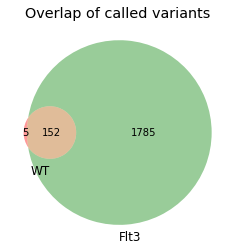

In [30]:
%matplotlib inline
venn2([set(wt_AF_by_cell.columns.values),set(flt3_AF_by_cell.columns.values)],set_labels=["WT","Flt3"])
plt.title("Overlap of called variants")
plt.savefig(join(outdir,"overlap_variants_with_without_ligand.png"))

## Plot the lineage tracing 

### With only the overlapping variants

In [18]:
all_cells_var_overlap = all_cells_var_overlap.drop((all_cells_var_overlap==0).all(axis=0).where(lambda x: x==True).dropna().index,axis=1)

all_cells_var_overlap = all_cells_var_overlap.drop((all_cells_var_overlap==0).all(axis=1).where(lambda x: x==True).dropna().index,axis=0)

In [19]:

row_meta = pd.concat((pd.DataFrame(index=flt3_AF_by_cell.index, data={"Sample":["Flt3"]*flt3_AF_by_cell.index.shape[0]}),
           pd.DataFrame(index= wt_AF_by_cell.index, data={"Sample":["wt"]*wt_AF_by_cell.index.shape[0]})))
row_meta = row_meta.loc[all_cells_var_overlap.index]
row_meta

,Sample
GCTTGAACAGCTCGCA-1_wt,wt
CCGTACTAGCCCGAAA-1_wt,wt
AGTGTCAGTTCAGACT-1_wt,wt
CAGAATCGTAAACCTC-1_wt,wt
GTAACTGCATCCAACA-1_wt,wt
...,...
ATCATCTAGGTGTTAA-1_flt3,Flt3
CTCATTAGTTGGAGGT-1_flt3,Flt3
ACAGCTATCTTTACGT-1_flt3,Flt3
CATTATCCAGACAAAT-1_flt3,Flt3


cmap None


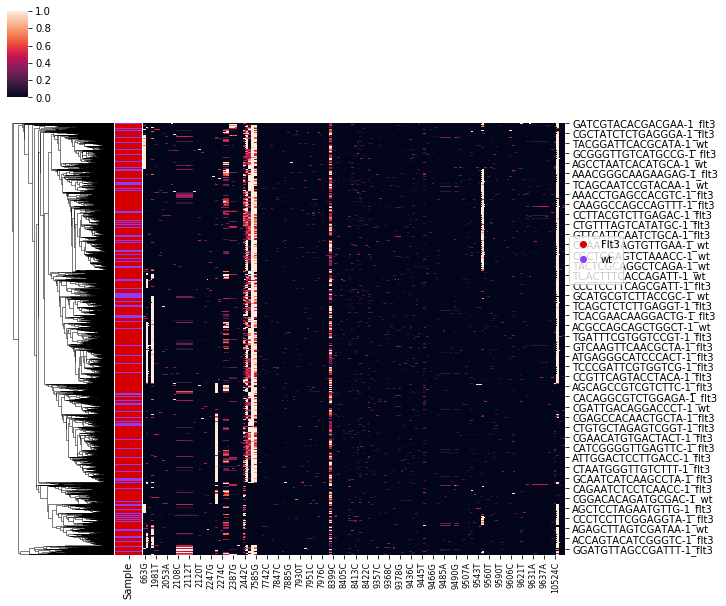

In [20]:
%matplotlib inline
cluster_help.plot_cluster(df=all_cells_var_overlap, row_meta=row_meta, col_meta=None,
                 fsave=None, to_z=False, to_col_clust=False,
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None)
plt.savefig(join(outdir,"lineage_OnlyoverlapVariants.png"))

## Plot number of overlapping positions from Flt3 and without

### With all variants

cmap None


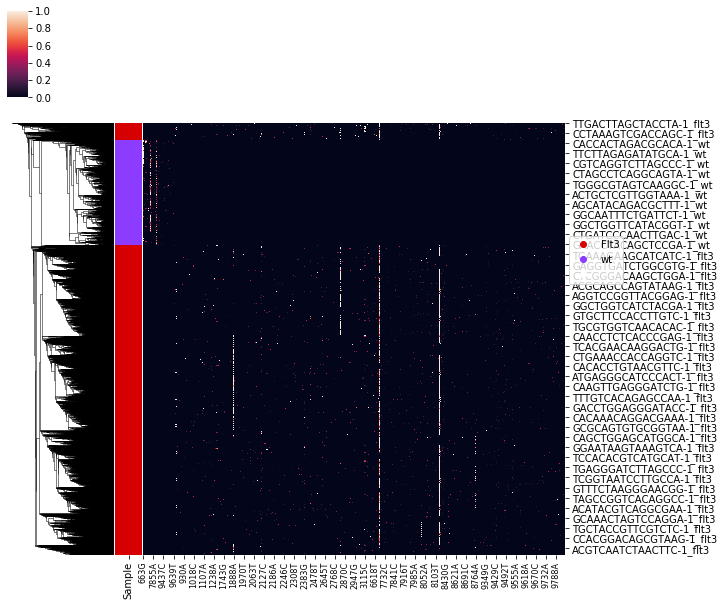

In [21]:
all_cells = all_cells.fillna(0)
all_cells = all_cells.drop((all_cells==0).all(axis=0).where(lambda x: x==True).dropna().index,axis=1)

all_cells = all_cells.drop((all_cells==0).all(axis=1).where(lambda x: x==True).dropna().index,axis=0)

# row_meta = pd.concat((pd.DataFrame(index=flt3_cell, data={"Sample":["Flt3"]*flt3_cell.shape[0]}),
#            pd.DataFrame(index=wt_cell, data={"Sample":["wt"]*wt_cell.shape[0]})))
# row_meta = row_meta.loc[all_cells.index]

row_meta = pd.concat((pd.DataFrame(index=flt3_AF_by_cell.index, data={"Sample":["Flt3"]*flt3_AF_by_cell.index.shape[0]}),
           pd.DataFrame(index= wt_AF_by_cell.index, data={"Sample":["wt"]*wt_AF_by_cell.index.shape[0]})))
row_meta = row_meta.loc[all_cells.index]
row_meta


g = cluster_help.plot_cluster(df=all_cells, row_meta=row_meta, col_meta=None,
                 fsave=None, to_z=False, to_col_clust=False,
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None)
plt.savefig(join(outdir,"lineage_AllVariants.png"))

## Scatter the average AF in both samples for each position 


[  663   709  1816 ... 14801 14803 14805]


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


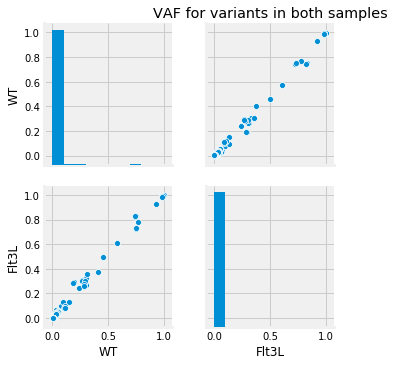

In [31]:
#pd.concat((wt_af, flt3_af))
import numpy as np
overlap_inds = np.array(list(map(lambda x: int(x[:-1]), all_cells.columns)))
print(overlap_inds)
merged_af = pd.DataFrame({"WT":wt_af.loc[overlap_inds,"AF"], "Flt3L":flt3_af.loc[overlap_inds, "AF"]})
merged_af = merged_af.fillna(0)
sns.pairplot(merged_af)
plt.title("VAF for variants in both samples")
plt.savefig(join(outdir, "heteroplasmy_across_samples"))

In [38]:
print('Both less than 0.2',(merged_af<0.02).all(axis=1).sum())
print('Both less than 0.2',(merged_af>0.02).any(axis=1).sum())

Both less than 0.2 2007
Both less than 0.2 87


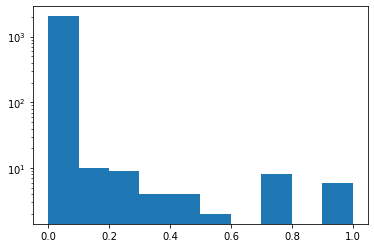

In [23]:
plt.hist((merged_af['WT'].astype(float)))
plt.yscale('log')

## Just using CD34 with no Flt3L

### Here we compare the rest of sequencing techniques done and see if we see the same variants, this ensuring the differences are consistent across the techniques and not technical noise.

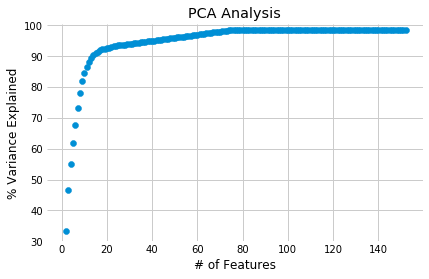

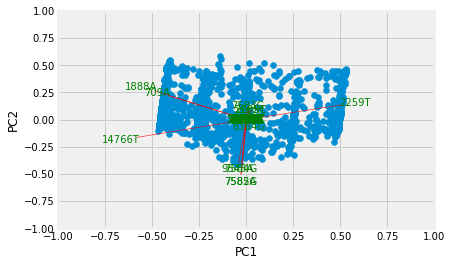

(                         2259T  2285C     2289T     2442C     7583G     7582A  \
 GCTTGAACAGCTCGCA-1_wt      0.0    0.0  0.000000  0.000000  0.333333  0.500000   
 CCGTACTAGCCCGAAA-1_wt      0.0    0.0  0.000000  0.500000  0.500000  0.500000   
 AGTGTCAGTTCAGACT-1_wt      1.0    0.0  0.000000  0.500000  0.000000  1.000000   
 CAGAATCGTAAACCTC-1_wt      0.0    0.0  0.000000  0.000000  0.000000  0.000000   
 GTAACTGCATCCAACA-1_wt      0.0    0.0  0.000000  0.250000  0.500000  0.500000   
 ...                        ...    ...       ...       ...       ...       ...   
 ATCATCTAGGTGTTAA-1_flt3    1.0    0.5  0.333333  0.333333  1.000000  0.000000   
 CTCATTAGTTGGAGGT-1_flt3    0.0    0.0  0.000000  0.000000  0.000000  0.000000   
 ACAGCTATCTTTACGT-1_flt3    0.0    0.0  0.000000  0.500000  0.666667  0.333333   
 CATTATCCAGACAAAT-1_flt3    0.0    0.5  0.600000  0.750000  0.000000  0.000000   
 ATAGACCTCTACTTAC-1_flt3    0.0    0.0  0.000000  0.083333  0.571429  0.428571   
 
              

<Figure size 432x288 with 0 Axes>

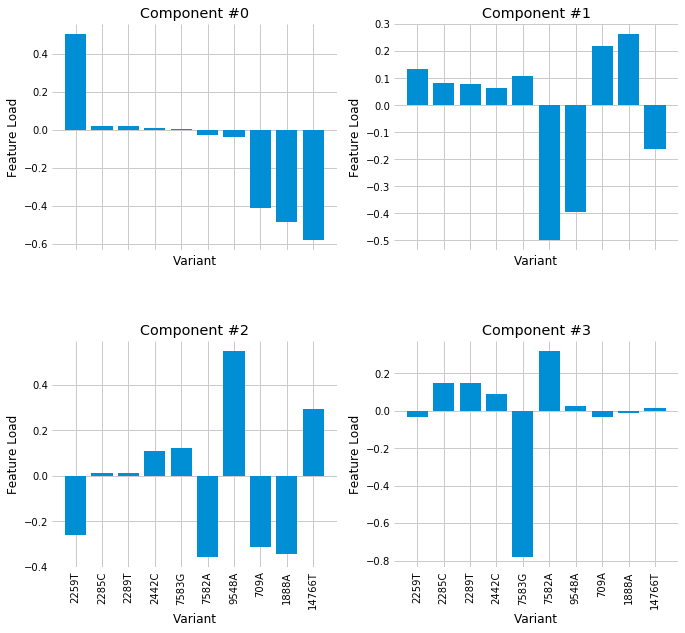

In [27]:
from src.utils import construct_pca
%matplotlib inline
construct_pca(all_cells_var_overlap.copy(), save_f=join(outdir, "pca"))

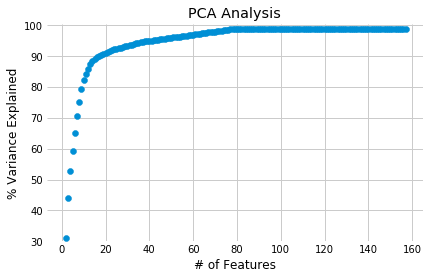

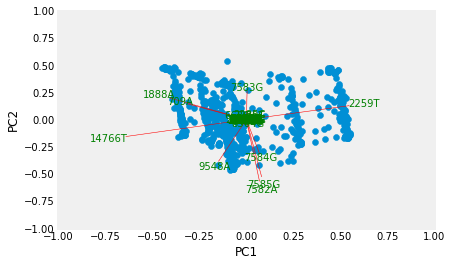

(                       2259T     7585G     7582A     8364G     7583G  663G  \
 GCTTGAACAGCTCGCA-1_wt    0.0  0.666667  0.500000  0.000000  0.333333   0.0   
 CCGTACTAGCCCGAAA-1_wt    0.0  1.000000  0.500000  1.000000  0.500000   0.0   
 AGTGTCAGTTCAGACT-1_wt    1.0  1.000000  1.000000  1.000000  0.000000   0.0   
 CAGAATCGTAAACCTC-1_wt    0.0  0.000000  0.000000  0.250000  0.000000   0.0   
 GTAACTGCATCCAACA-1_wt    0.0  1.000000  0.500000  0.666667  0.500000   0.0   
 ...                      ...       ...       ...       ...       ...   ...   
 ACAGCCGGTTTCGCTC-1_wt    0.0  1.000000  0.666667  0.500000  0.333333   1.0   
 CGTTAGAGTGAGGGTT-1_wt    1.0  1.000000  0.000000  0.500000  1.000000   0.0   
 AAAGCAACAAGTACCT-1_wt    0.0  0.000000  0.000000  0.500000  0.000000   0.0   
 CCGGGATCACATCCGG-1_wt    0.0  0.666667  0.000000  0.500000  1.000000   0.0   
 AGCTCCTTCTGCAGTA-1_wt    0.0  0.666667  0.000000  0.666667  1.000000   0.0   
 
                        9548A  709A  1888A    1476

<Figure size 432x288 with 0 Axes>

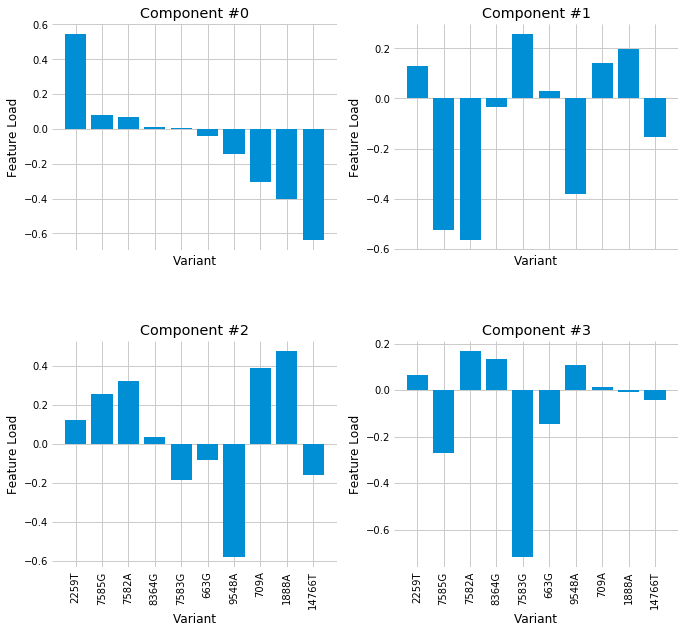

In [24]:
from src.utils import construct_pca
%matplotlib inline
construct_pca(wt_AF_by_cell.copy(), save_f=join(outdir, "wt_pca"))

## Het by value

## Clustering

In [25]:
wt_AF_by_cell

,663G,709A,1816C,1888A,1981T,1983G,1999C,2047A,2053A,2080A,...,9634G,9636T,9637A,9639T,9643T,9645T,10524C,14766T,14776C,14780C
GCTTGAACAGCTCGCA-1_wt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0
CCGTACTAGCCCGAAA-1_wt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0
AGTGTCAGTTCAGACT-1_wt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
CAGAATCGTAAACCTC-1_wt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.000000,0.0,0.0
GTAACTGCATCCAACA-1_wt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACAGCCGGTTTCGCTC-1_wt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,1.000000,0.0,0.0
CGTTAGAGTGAGGGTT-1_wt,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.285714,0.0,0.0
AAAGCAACAAGTACCT-1_wt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
CCGGGATCACATCCGG-1_wt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


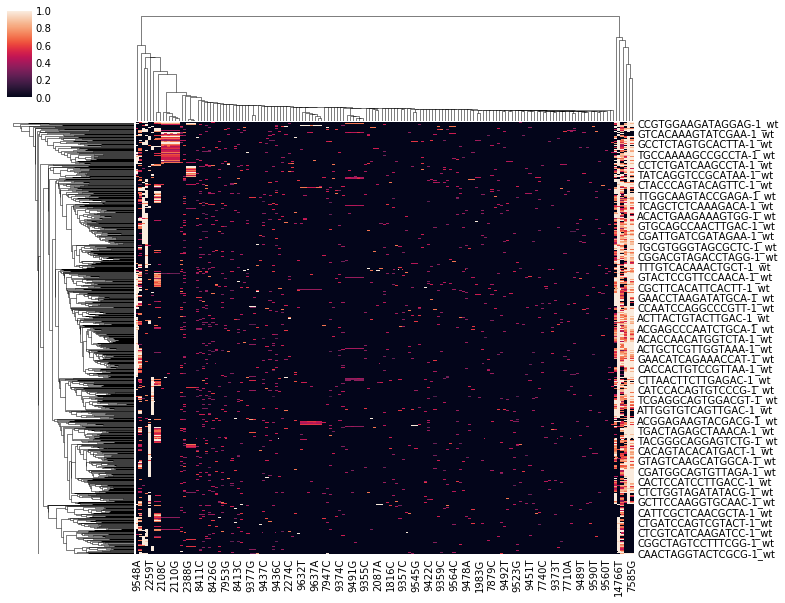

In [26]:
wt_AF_by_cell = wt_AF_by_cell.loc[:,(wt_AF_by_cell>0).any(axis=0)]
sns.clustermap(np.sqrt(wt_AF_by_cell), )